In [1]:
import pandas as pd
import IPython
import IPython.display
import numpy as np
import tensorflow as tf
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from KMlib.metrics import total_score
from KMlib.plot_metrics import plot_loss,plot_test
from KMlib.naive_processing import get_submit_data
from KMlib.processing import pr_scaling,x_scaling,Processer,get_test_data, WindowGenerator

In [105]:
df = pd.read_csv(r'../data/complete_feature.csv',index_col = 0)
input_width = 30
label_width = 30
shift = 30
col = ['total_purchase_amt', 'total_redeem_amt','consume_amt', 'transfer_amt','month', 'day',
       'weekday', 'dis_to_nowork','dis_from_nowork','dis_to_work', 'dis_from_work', 'dis_from_holiday',
       'dis_to_holiendday','dis_from_endofweek', 'dis_from_purchase_peak','dis_from_purchase_valley',
       'user_id','mfd_daily_yield'] 
df = df[col]
df1 =  df.loc[:"2014-08-31"]
batch_size = 4

In [106]:
## purchase
x_scaler= MinMaxScaler(feature_range=(0, 1))
py_scaler = MinMaxScaler(feature_range=(0, 1))
train_df = pd.DataFrame(x_scaler.fit_transform(df.iloc[:-30-input_width]),columns = df.columns,index = df.iloc[:-30-input_width].index)
val_df = pd.DataFrame(x_scaler.transform(df1.iloc[-30-input_width:]),columns = df.columns,index = df1.iloc[-30-input_width:].index)
test_df = pd.DataFrame(x_scaler.transform(df.iloc[-31-input_width:-1])
                       ,columns = df.iloc[-31-input_width:-1].columns,index = df.iloc[-31-input_width:-1].index)

In [107]:
label_columns = ['total_purchase_amt']
py_scaler.fit(df.iloc[:-input_width][label_columns])
purchase = WindowGenerator(input_width, label_width, shift,batch_size, train_df, val_df, test_df, label_columns)

## Redeem

In [108]:
## purchase
x_scaler= MinMaxScaler(feature_range=(0, 1))
ry_scaler = MinMaxScaler(feature_range=(0, 1))
train_df = pd.DataFrame(x_scaler.fit_transform(df.iloc[:-30-input_width]),columns = df.columns,index = df.iloc[:-30-input_width].index)
val_df = pd.DataFrame(x_scaler.transform(df1.iloc[-30-input_width:]),columns = df.columns,index = df1.iloc[-30-input_width:].index)
test_df = pd.DataFrame(x_scaler.transform(df.iloc[-31-input_width:-1])
                       ,columns = df.iloc[-31-input_width:-1].columns,index = df.iloc[-31-input_width:-1].index)
label_columns = ['total_redeem_amt']
ry_scaler.fit(df.iloc[:-30-input_width][label_columns])
redeem = WindowGenerator(input_width, label_width, shift,batch_size, train_df, val_df, test_df, label_columns)

In [109]:
# redeem.plot_example = example_inputs, example_labels
# redeem.plot(plot_col='total_redeem_amt')

In [123]:
def get_r_model( window,MAX_EPOCHS = 80, patience=20):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience,mode='min')
    model =tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=7,strides=1, padding="causal",activation="tanh"),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(30)])
    optimizer=tf.optimizers.Adam()
    model.compile(loss="mae", optimizer=optimizer)
    history = model.fit(window.train, epochs=MAX_EPOCHS,validation_data=window.val,callbacks = [early_stopping])
    return model,history

In [122]:
def get_model( window,MAX_EPOCHS = 80, patience=80):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience,mode='min')
    model =tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=7,strides=1, padding="causal",activation="tanh"),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(40, activation="relu"),
    tf.keras.layers.Dense(30)])
    optimizer=tf.optimizers.Adam()
    model.compile(loss="mae", optimizer=optimizer)
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,callbacks = [early_stopping])
    return model,history

In [124]:
tf.keras.backend.clear_session()
tf.random.set_seed(7)
np.random.seed(7)
epochs = 100
r_model,r_history = get_r_model(redeem,epochs)
IPython.display.clear_output()

In [129]:
tf.keras.backend.clear_session()
tf.random.set_seed(7)
np.random.seed(21)
epochs = 100
p_model,p_history = get_model(redeem,epochs)
IPython.display.clear_output()

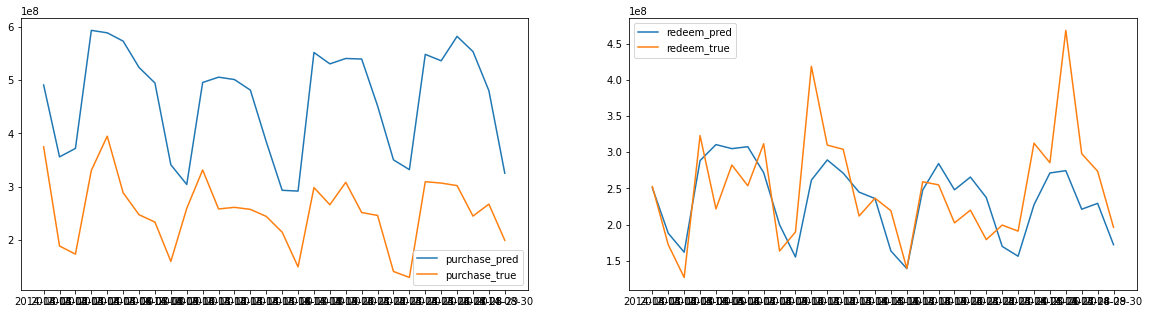

56.139524000192495

In [128]:
redeem_pred = ry_scaler.inverse_transform(r_model.predict(test_df.iloc[:input_width,:].values[np.newaxis,...])[0].reshape(-1,1)).reshape(30,)
purchase_pred = py_scaler.inverse_transform(p_model.predict(test_df.iloc[:input_width,:].values[np.newaxis,...])[0].reshape(-1,1)).reshape(30,)
purchase_true = df.loc["2014-08-01":"2014-08-30"].iloc[:, 0]
redeem_true = df.loc["2014-08-01":"2014-08-30"].iloc[:, 1]

plot_test(purchase_pred,purchase_true,redeem_pred,redeem_true)
total_score(purchase_pred,purchase_true,redeem_pred,redeem_true)

## AR LSTM

In [56]:
def compile_and_fit(model, window, patience=10):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=80,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [57]:
num_features = df.shape[1]
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [58]:
feedback_model = FeedBack(units=32, out_steps=30)
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [59]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the lstm state
    prediction, state = self.warmup(inputs)

    # Insert the first prediction
    predictions.append(prediction)

    # Run the rest of the prediction steps
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

In [60]:
history = compile_and_fit(feedback_model, purchase)

IPython.display.clear_output()

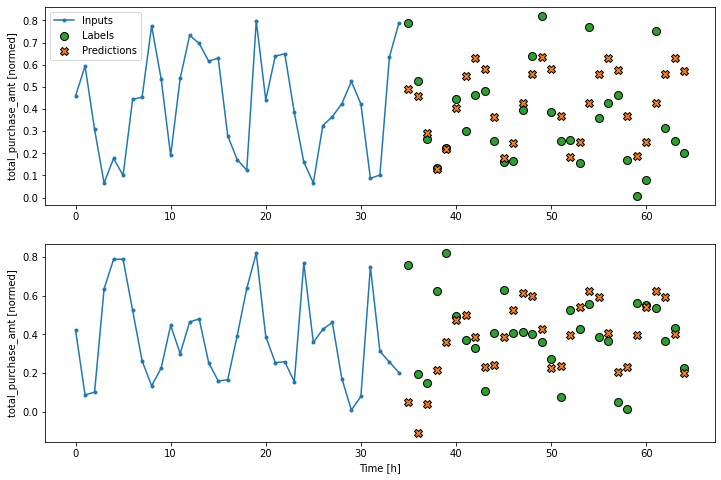

In [61]:
purchase.plot(feedback_model,plot_col = "total_purchase_amt")

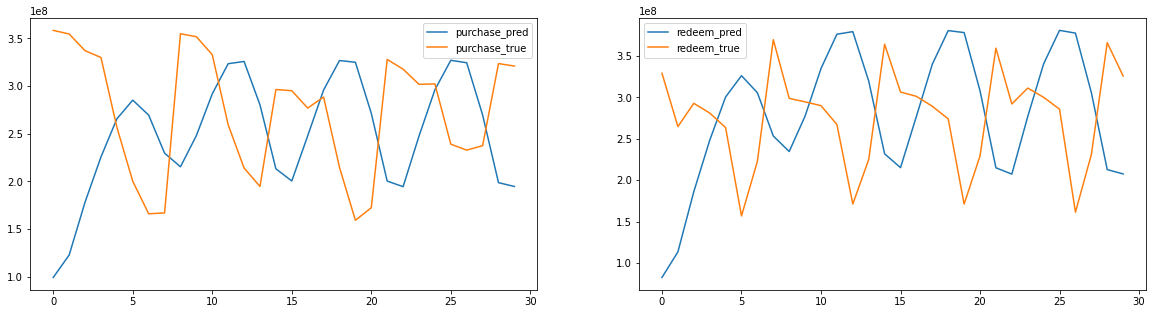

In [63]:
redeem_pred = ry_scaler.inverse_transform(feedback_model.predict(test_df.iloc[input_width:,:].values[np.newaxis,...])[0,:,0].reshape(-1,1))
purchase_pred = py_scaler.inverse_transform(feedback_model.predict(test_df.iloc[input_width:,:].values[np.newaxis,...])[0,:,0].reshape(-1,1))
df_true = pd.read_csv('tc_comp_predict_table_137.6.csv',header = None)
purchase_true = df_true.iloc[:, 1]
redeem_true = df_true.iloc[:, 2]
# plt.plot(purchase_true)
# plt.plot(redeem_true)
plot_test(purchase_pred,purchase_true,redeem_pred,redeem_true)